# Setup: Initialize neuprint client and get clock dataframe

User must input own neuprint token

In [1]:
import pandas as pd
from neuprint import Client
c = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token='[insert token here]') 
c.fetch_version()

'0.1.0'

In [2]:
from neuron_criteria import getClock
clock_df = getClock(l_lnv=True)

# Creating connection summary table with all information

## Use fetch_adjacencies to get all of the post-synaptic targets of the clock neurons

In [4]:
from connection_utils import clock_neuron_connections, synapse_count, synaptic_partner_numbers

In [6]:
# get inputs from clock neurons to anything else
outconns_df = clock_neuron_connections(clock_df, 'out')
# get inputs to clock neurons from anything else
inconns_df = clock_neuron_connections(clock_df, 'in')

In [7]:
# get total output synapse count for clock neurons
outsyns_df = synapse_count(outconns_df, 'out')
# get total input synapse count for clock neurons
insyns_df = synapse_count(inconns_df, 'in')

In [8]:
# use pandas merge to add columns to outsyns_df
# instance names as leftmost column, column for number of postsynaptic partners to the right
# add columns in and then rearrange
conn_summary_df = outsyns_df.merge(clock_df, 'right', on='bodyId')
conn_summary_df = conn_summary_df.merge(insyns_df, 'left', on='bodyId')
conn_summary_df = conn_summary_df[['seqInstance','bodyId','num_out_syns','num_in_syns']]

## Numbers of pre or postsynaptic partners

In [9]:
# get number of postsynaptic partners from outconns_df and merge onto conn_summary_df table
outpartners_df = synaptic_partner_numbers(outconns_df, 'out')
conn_summary_df = conn_summary_df.merge(outpartners_df, 'left', on='bodyId')

In [10]:
# get number of presynaptic partners from inconns_df and merge onto conn_summary_df table
inpartners_df = synaptic_partner_numbers(inconns_df, 'in')
conn_summary_df = conn_summary_df.merge(inpartners_df, 'left', on='bodyId')

In [11]:
#select specific columns in the order we want them displayed
conn_summary_df = conn_summary_df[['seqInstance','bodyId','num_in_syns','num_presyn_partners','num_out_syns','num_postsyn_partners']]

## Connections and numbers of input and output synapses made from/to other clock neurons

In [12]:
#getting the connections between clock neurons
clock_conns_df = clock_neuron_connections(clock_df, 'intra_clock')

In [13]:
# get total output synapse count for clock neurons
clock_syns_out_df = synapse_count(clock_conns_df, 'out', intra_clock=True)
# get total input synapse count for clock neurons
clock_syns_in_df = synapse_count(clock_conns_df, 'in', intra_clock=True)

## Numbers of post or presynaptic partners of clock neurons

In [14]:
# get number of postsynaptic partners of the clock neurons using value_counts of the pre-synaptic bodyIds
out_clock_partners_df = synaptic_partner_numbers(clock_conns_df, 'out', intra_clock=True)
# get number of presynaptic partners of the clock neurons using value_counts of the post-synaptic bodyIds
in_clock_partners_df = synaptic_partner_numbers(clock_conns_df, 'in', intra_clock=True)

In [15]:
#add to the summary table: the number of in and out synapses made from clock neurons on other clock neurons and the number of unique partners for each
conn_summary_df = conn_summary_df.merge(clock_syns_out_df, on='bodyId')
conn_summary_df = conn_summary_df.merge(out_clock_partners_df, on='bodyId')
conn_summary_df = conn_summary_df.merge(clock_syns_in_df, on='bodyId')
conn_summary_df = conn_summary_df.merge(in_clock_partners_df, on='bodyId')

# Bar plot of LN input and output synapse counts

In [36]:
# condition conn_summary_df to get data we want to plot in a specific order
LNs_conns = conn_summary_df.reindex([0,1,2,3,8,9,10,4,5,6,7]) #only the LNs

labels_clock_df = clock_df[['bodyId', 'labels']]
LNs_conns = LNs_conns.merge(labels_clock_df, on='bodyId')

# make a column that is total synapses minus clock synapses for stacked bar plot


<Figure size 800x800 with 0 Axes>

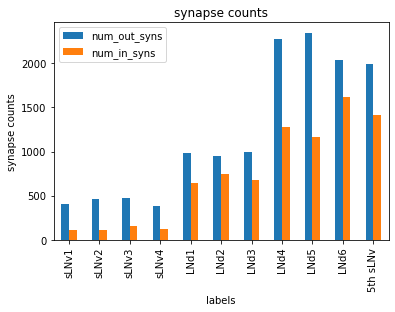

In [35]:
from numpy.lib.npyio import save
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# make the bar plot
figure(figsize=(10,10), dpi=80)
LNs_conns.plot.bar(x='labels',y=['num_out_syns','num_in_syns'],ylabel='synapse counts')
plt.title("synapse counts")
plt.savefig("barplot_LN_syncount.svg")

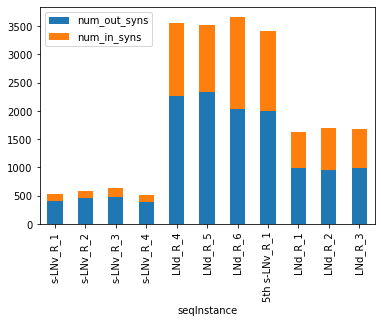

In [37]:
# make the bar plot with stacked columns
# this is a test. might stack clock and non-clock synapses.
ax = conn_summary_df[0:11].plot.bar(x='seqInstance',y=['num_out_syns','num_in_syns'],stacked=True)

# Class Intra-connectivity/Connectivity ratios

In [49]:
def intra_conns(clock_df, type_or_phase):
    """
    Retrieve body ids within each type/phase then retreieve only those rows where both in and out are of the same type. Concatenate row-wise
    :param clock_df: clock dataframe
    :param type_or_phase: (string) whether to call the function on each type or each phase.
    :return:
    """
    from neuprint import fetch_adjacencies
    
    intra_conns = []
    
    if type_or_phase == 'type':
        unique = clock_df.type.unique()
        class_or_me = 'class'
    if type_or_phase == 'phase':
        unique = clock_df.phase.unique()
        class_or_me = 'me'

    for t in unique:
        ids = clock_df[clock_df[type_or_phase] == t]['bodyId'].tolist()
        neuron_df, conn_df = fetch_adjacencies(ids, ids)
        out_df = conn_df.groupby(['bodyId_pre'], as_index=False)['weight'].sum() 
        in_df = conn_df.groupby(['bodyId_post'], as_index=False)['weight'].sum()
        conns = pd.merge(in_df, out_df.set_index('bodyId_pre'), left_on = 'bodyId_post', right_index = True)
        conns = conns.rename(columns={"bodyId_post":"bodyId","weight_x":f"{class_or_me}_syn_in","weight_y":f"{class_or_me}_syn_out"})
        intra_conns.append(conns)

    conns = pd.concat(intra_conns)
    if type_or_phase == 'phase':
        me_ids = clock_df[clock_df['phase'] != '']['bodyId'].tolist()
        conns = conns[conns['bodyId'].isin(me_ids)]
    return conns

In [53]:
type_conns = intra_conns(clock_df, 'type')
me_conns = intra_conns(clock_df, 'phase')

#Merge onto summary table
conn_summary_df = conn_summary_df.merge(type_conns, how = 'left', on='bodyId')
conn_summary_df = conn_summary_df.merge(me_conns, how = 'left', on='bodyId')

# Export connection summary table as csv file

In [59]:
conn_summary_df.to_csv('single_neuron_summ.csv')
conn_summary_df

,seqInstance,bodyId,num_in_syns,num_presyn_partners,num_out_syns,num_postsyn_partners,num_clock_out_syns,num_clock_postsyn_partners,num_clock_in_syns,num_clock_presyn_partners,class_syn_in,class_syn_out,me_syn_in,me_syn_out
0,s-LNv_R_1,2068801704,113,44,411,73,21,6,16,5,12.0,18.0,12.0,18.0
1,s-LNv_R_2,1664980698,112,34,464,74,10,3,10,3,9.0,10.0,9.0,10.0
2,s-LNv_R_3,2007068523,159,63,472,66,14,4,17,5,13.0,13.0,13.0,13.0
3,s-LNv_R_4,1975347348,121,42,386,66,8,2,16,4,15.0,8.0,15.0,8.0
4,LNd_R_4,5813056917,1278,363,2272,520,5,3,94,12,36.0,3.0,54.0,3.0
5,LNd_R_5,5813021192,1169,319,2343,525,9,4,95,13,22.0,6.0,47.0,6.0
6,LNd_R_6,5813069648,1621,226,2040,538,156,16,358,11,1.0,52.0,41.0,89.0
7,5th s-LNv_R_1,511051477,1413,220,1992,492,159,20,295,13,NaN,NaN,37.0,84.0
8,LNd_R_1,296544364,648,241,988,305,9,2,10,3,9.0,9.0,9.0,9.0
9,LNd_R_2,448260940,750,326,949,348,7,3,13,6,9.0,6.0,9.0,6.0


# Group Summary

In [56]:
def group_summary(conn_summary_df, clock_df, type_or_phase):
    """
    :param conn_summary_df: connection summary table
    :param clock_df: clock dataframe
    :type_or_phase: (string) whether to group by type or phase
    :return:
    """
    #Merge type back on for easy grouping
    conn_group_df = conn_summary_df.merge(clock_df[['bodyId', type_or_phase]])

    #Use group_by to get summations
    conn_group_df = conn_group_df.groupby([type_or_phase]).sum()
    del conn_group_df['bodyId']

    # Subtract out class synapses and reorder
    class_synapses = conn_group_df['class_syn_in']
    conn_group_df = conn_group_df.sub(class_synapses, axis = 0)
    conn_group_df['class_syn_in'] = class_synapses

    if type_or_phase == 'type':
        groups = ['l-LNv', 's-LNv', '5th s-LNv', 'LNd', 'LPN', 'DN1a', 'DN1pA', 'DN1pB']
        conn_group_df = conn_group_df.reindex(groups)

    # reorder columns
    conn_group_df = conn_group_df[['num_in_syns', 'num_presyn_partners', 'num_out_syns', 'num_postsyn_partners', 'class_syn_in', 'num_clock_in_syns', 'num_clock_out_syns']]
    return conn_group_df

In [57]:
conn_type_df = group_summary(conn_summary_df, clock_df, 'type')
conn_type_df.to_csv('class_conn_summ.csv')
conn_type_df

,num_in_syns,num_presyn_partners,num_out_syns,num_postsyn_partners,class_syn_in,num_clock_in_syns,num_clock_out_syns
type,,,,,,,
l-LNv,1497.0,258.0,228.0,121.0,16.0,5.0,3.0
s-LNv,456.0,134.0,1684.0,230.0,49.0,10.0,4.0
5th s-LNv,1413.0,220.0,1992.0,492.0,0.0,295.0,159.0
LNd,6064.0,1627.0,9505.0,2416.0,85.0,496.0,110.0
LPN,3139.0,771.0,4588.0,941.0,86.0,47.0,19.0
DN1a,2341.0,377.0,2832.0,455.0,22.0,11.0,286.0
DN1pA,2034.0,731.0,2493.0,866.0,20.0,134.0,359.0
DN1pB,1833.0,557.0,3468.0,840.0,10.0,23.0,81.0


In [58]:
me_df = group_summary(conn_summary_df, clock_df, 'phase')
me_df.to_csv('me_conn_summ.csv')
me_df

,num_in_syns,num_presyn_partners,num_out_syns,num_postsyn_partners,class_syn_in,num_clock_in_syns,num_clock_out_syns
phase,,,,,,,
,10844.0,2694.0,13609.0,3223.0,154.0,220.0,748.0
evening,7477.0,1847.0,11497.0,2908.0,85.0,791.0,269.0
morning,456.0,134.0,1684.0,230.0,49.0,10.0,4.0
